<a href="https://colab.research.google.com/github/kenzfinn/csc1035_lecture_examples/blob/master/CSC3831_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms
import seaborn as sns

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset with transformations
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

train_size = int(0.8 * len(dataset)) #training is 80% of the dataser
val_size = len(dataset) - train_size #validation set is the rest
train_set, val_set = random_split(dataset, [train_size, val_size]) #splits them into validation adn training set
train_loader = DataLoader(train_set, batch_size=64, shuffle=True) #loads the training set to batches of 64
val_loader = DataLoader(val_set, batch_size=64, shuffle=False) #loads the validation set to batches of 64

100%|██████████| 170M/170M [00:04<00:00, 41.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [2]:
class CNNWithBN(nn.Module):
    def __init__(self):
        super(CNNWithBN, self).__init__()
        self.convl1 = nn.Conv2d(3, 32, 3,stride=1, padding=1)
        #input 3, output 32, 3 kernel size(stays the same)
        self.conv2 = nn.Conv2d(32, 64, 3,stride=1, padding=1)
        #input 32 output 64
        self.conv3 = nn.Conv2d(64, 128, 3, stride = 1, padding=1)
        #input 64 output 128
        self.fc1 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        #reduces 2048 to the 10 classifiers
        #batch normalisation layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        #normilises based on the output of the conv layer before
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)



    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.convl1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        #flat before FC

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class CNNWithoutBN(CNNWithBN):
    def __init__(self):
        super(CNNWithoutBN, self).__init__()
        #overwrites the batch normalisation in using the superclass
        self.bn1 = nn.Identity()
        self.bn2 = nn.Identity()
        self.bn3 = nn.Identity()
        #these overwrite the batch normalisation layers to just return the input

In [3]:
def train_model(model, train_loader, val_loader, epochs=50, patience=5):
    training_log = []
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    best_loss = float('inf')
    patience_counter = 0
    best_model = None
    #these all used for early stopping and best model

    for epoch in range(epochs):
        model.train()
        #train the model for each epoch
        train_loss = 0.0
        #resets training loss
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            #clears optimiser
            outputs = model(inputs)
            #computes outputs based on inputs with model
            loss = criterion(outputs, targets)
            #compares the output(predicions) to the target and uses the loss function to calculate loss
            loss.backward()
            optimizer.step()
            #goes backward then forwards to update parameters
            train_loss += loss.item()

        # Validation
        model.eval()
        #evaluates model
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                #same as train_loss but parameters aren't updated due to the 'unseen' images

        print(f"Epoch {epoch+1} : Train Loss={train_loss/len(train_loader)}, Val Loss={val_loss/len(val_loader)}")
        epoch_data = {
        "epoch": epoch,
        "training_loss": train_loss/len(train_loader),
        "validation_loss": val_loss/len(val_loader)
        }
        training_log.append(epoch_data)
        #creates the epoch data dictionaries and adds to the list

        # early stopping occurs when validation loss doesn't change after a certain patience (numer of epochs)
        if val_loss < best_loss:
            best_loss = val_loss
            #initialised as infinity so first val_loss always 'best loss'
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopp")
                break

    # Save the best model
    torch.save(best_model, 'best_model.pth')
    return best_model, training_log


In [4]:
model_with_bn = CNNWithBN()
model_without_bn = CNNWithoutBN()

import torch
if torch.cuda.is_available():
    print(f"CUDA is available. GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")
# Train models one with batch normalisation one without,
# models also output epoch data used for convergence graphs so create list opbjects to store epoch dicts
bn_training_log = []
non_bn_training_log = []
best_model_bn, bn_training_log = train_model(model_with_bn, train_loader, val_loader)
#best_model_wo_bn, no_bn_training_log = train_model(model_without_bn, train_loader, val_loader)


CUDA is available. GPU name: Tesla T4
Epoch 1 : Train Loss=1.2618211660385132, Val Loss=0.9564942322718869
Epoch 2 : Train Loss=0.8734499174118042, Val Loss=0.9723413222154994
Epoch 3 : Train Loss=0.7213942792415619, Val Loss=0.8243943450936846
Epoch 4 : Train Loss=0.614599774837494, Val Loss=0.7879196843903535
Epoch 5 : Train Loss=0.5316235369205475, Val Loss=0.7917738949796956
Epoch 6 : Train Loss=0.45858043437004087, Val Loss=0.7608611308465338
Epoch 7 : Train Loss=0.38896345578432084, Val Loss=0.7851172976053444
Epoch 8 : Train Loss=0.3304176871180534, Val Loss=0.732232962254506
Epoch 9 : Train Loss=0.2762180349349976, Val Loss=0.782678679675813
Epoch 10 : Train Loss=0.2304587681889534, Val Loss=0.7410310428043839
Epoch 11 : Train Loss=0.19261114324331283, Val Loss=0.8128224569521133
Epoch 12 : Train Loss=0.1589035254895687, Val Loss=0.8996199872463372
Epoch 13 : Train Loss=0.13355168741643428, Val Loss=1.012583491149222
Early stopp


In [5]:
best_model_wo_bn, no_bn_training_log = train_model(model_without_bn, train_loader, val_loader)

KeyboardInterrupt: 

In [ ]:

epochs = [entry["epoch"] for entry in bn_training_log]
training_losses = [entry["training_loss"] for entry in bn_training_log]
validation_losses = [entry["validation_loss"] for entry in bn_training_log]

# Plot the losses
plt.plot(epochs, training_losses, label="Training Loss", marker='o', color='blue')
plt.plot(epochs, validation_losses, label="Validation Loss", marker='o', color='orange')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss in CNN with batch normalisation")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epochs = [entry["epoch"] for entry in no_bn_training_log]
training_losses = [entry["training_loss"] for entry in no_bn_training_log]
validation_losses = [entry["validation_loss"] for entry in no_bn_training_log]

# Plot the losses
plt.plot(epochs, training_losses, label="Training Loss", marker='o', color='blue')
plt.plot(epochs, validation_losses, label="Validation Loss", marker='o', color='orange')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss in CNN without batch normalisation")
plt.legend()
plt.grid(True)
plt.show()

filters for the first conv layer


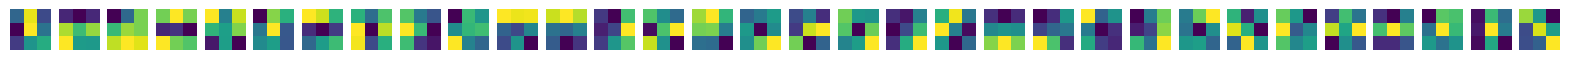

filters for second conv layer


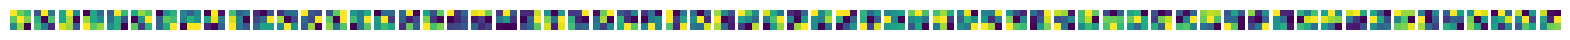

In [12]:
# https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
# This was used to further my understand for the third part of the coursework

from matplotlib import pyplot

model = model_with_bn
# retrieve weights from the second hidden layer



first_layer = list(model.children())[0]  # Adjust the index as needed
filters = first_layer.weight.data.cpu().numpy()  # Get weights
biases = first_layer.bias.data.cpu().numpy()
out_channels, in_channels, height, width = filters.shape
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print('filters for the first conv layer')
fig, axes = plt.subplots(1, out_channels, figsize=(20, 5))
for i, ax in enumerate(axes):
    # Visualize the first input channel of each filter (if multi-channel, you can iterate over `in_channels`)
    ax.imshow(filters[i, 0, :, :], cmap='viridis')  # Assuming you want the first input channel
    ax.axis('off')

plt.show()

second_layer = list(model.children())[1]  # Adjust the index as needed
filters = second_layer.weight.data.cpu().numpy()  # Get weights
biases = second_layer.bias.data.cpu().numpy()
out_channels, in_channels, height, width = filters.shape
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print('filters for second conv layer')
fig, axes = plt.subplots(1, out_channels, figsize=(20, 5))
for i, ax in enumerate(axes):
    # Visualize the first input channel of each filter (if multi-channel, you can iterate over `in_channels`)
    ax.imshow(filters[i, 0, :, :], cmap='viridis')  # Assuming you want the first input channel
    ax.axis('off')

plt.show()

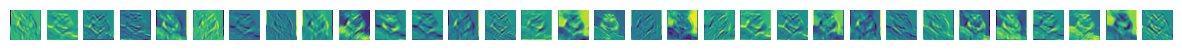

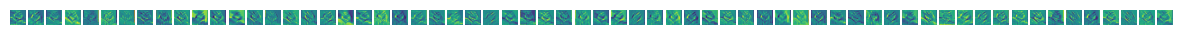

In [13]:
def visualize_conv_filters(model, image, layers):
  image = image.unsqueeze(0)

  outputs = []
  x = image
  for layer in layers:
    x = layer(x)
    outputs.append(x)


  for idx, feature_map in enumerate(outputs):
    feature_map = feature_map.squeeze(0).detach().cpu().numpy()
    num_features = feature_map.shape[0]

    plt.figure(figsize=(15, 15))
    for i in range(num_features):
      plt.subplot(1, num_features, i+1)
      plt.imshow(feature_map[i], cmap='viridis')
      plt.axis('off')



vis_layers = [model.convl1, model.conv2, model.conv3]

visualize_conv_filters(model_with_bn, train_set[0][0], vis_layers)
